In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.models import Model
import os
import cv2
import shutil
from glob import glob
from pathlib import Path
import random
from patchify import patchify, unpatchify

SEED = 42

# Python & NumPy
random.seed(SEED)
np.random.seed(SEED)

# TensorFlow
tf.random.set_seed(SEED)

# cuDNN convolution (optional but recommended)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

In [2]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# Load the model you trained in task5_training.ipynb
from tensorflow.keras.models import load_model
patch_size = 256
example_file_name = f'maciej_czerniak_243552_multiclass_unet_model_patchsize{patch_size}px.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

In [4]:
# Define any functions you need to process the mask e.g. Task 2
def extract_dish(img):
    # height, widh, center of image
    height, widh = img.shape
    center = (widh // 2, height // 2)

    # apply Otsu thresholding
    th, output_im = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    print(f'Otsu algorithm selected the following threshold: {th}')

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

    # the biggest blob (object) on each image is Petri dish
    # -infinity - to ensure any score is better
    best_label, best_score = None, -np.inf

    # in loop center is used since Petri dish is near center
    for lab in range(1, num_labels):
        """
        range(1...) - skip label 0 as it is the background
        stats are in format: [x, y, w, h, area] where:
            x.y - top-left corner
            w,h - width and height
            area - area in pixels
        centroids are in format: [cx, cy]
        """
        x, y, w, h, area = stats[lab]
        cx, cy = centroids[lab]

        # big area, near center, square shape
        area_score = area
        center_score = -np.linalg.norm([cx - widh/2, cy - height/2])
        
        #checking aspect ratio
        aspect = w / h
        square_score = -abs(aspect - 1.0)

        # check scores weights (area, square, center)
        score = (1.0 * area_score + 500.0 * square_score + 1000.0 * center_score)

        if score > best_score:
            best_score, best_label = score, lab
    
    x, y, w, h, area = stats[best_label]

    # ensure square that the Pertri dish is fully inside margin is added
    margin = 20
    x_m = max(x - margin, 0)
    y_m = max(y - margin, 0)

    # crop
    side = min(w, h)
    x2 = x + side + margin
    y2 = y + side + margin
    crop = img[y_m:y2, x_m:x2]

    # check crop is square
    assert crop.shape[0] == crop.shape[1], "Crop is not square!"
    bbox = (y_m, y2, x_m, x2)
    return crop, bbox


def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image, (top_padding, bottom_padding, left_padding, right_padding)

In [5]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
image = cv2.imread(task5_test_image_path, 0)
h, w = image.shape
print(h, w)

3006 4112


In [6]:
petri_dish, bbox = extract_dish(image)

Otsu algorithm selected the following threshold: 90.0


In [7]:
# Find the petri dish
petri_dish.shape

(2740, 2740)

In [8]:
# Pad the petri dish
patch_size = 256
petri_dish_padded, padding = padder(petri_dish, patch_size)
petri_dish_padded = cv2.cvtColor(petri_dish_padded, cv2.COLOR_GRAY2RGB)
petri_dish_padded.shape

(2816, 2816, 3)

In [9]:
petri_dish_padded.shape[0] % patch_size, petri_dish_padded.shape[1] % patch_size

(0, 0)

patches_for_model: (121, 256, 256, 3)
4/4 [==============================] - 11s 567ms/step
predicted_masks shape: (121, 256, 256, 4)
Labels:
[0 1 2 3]


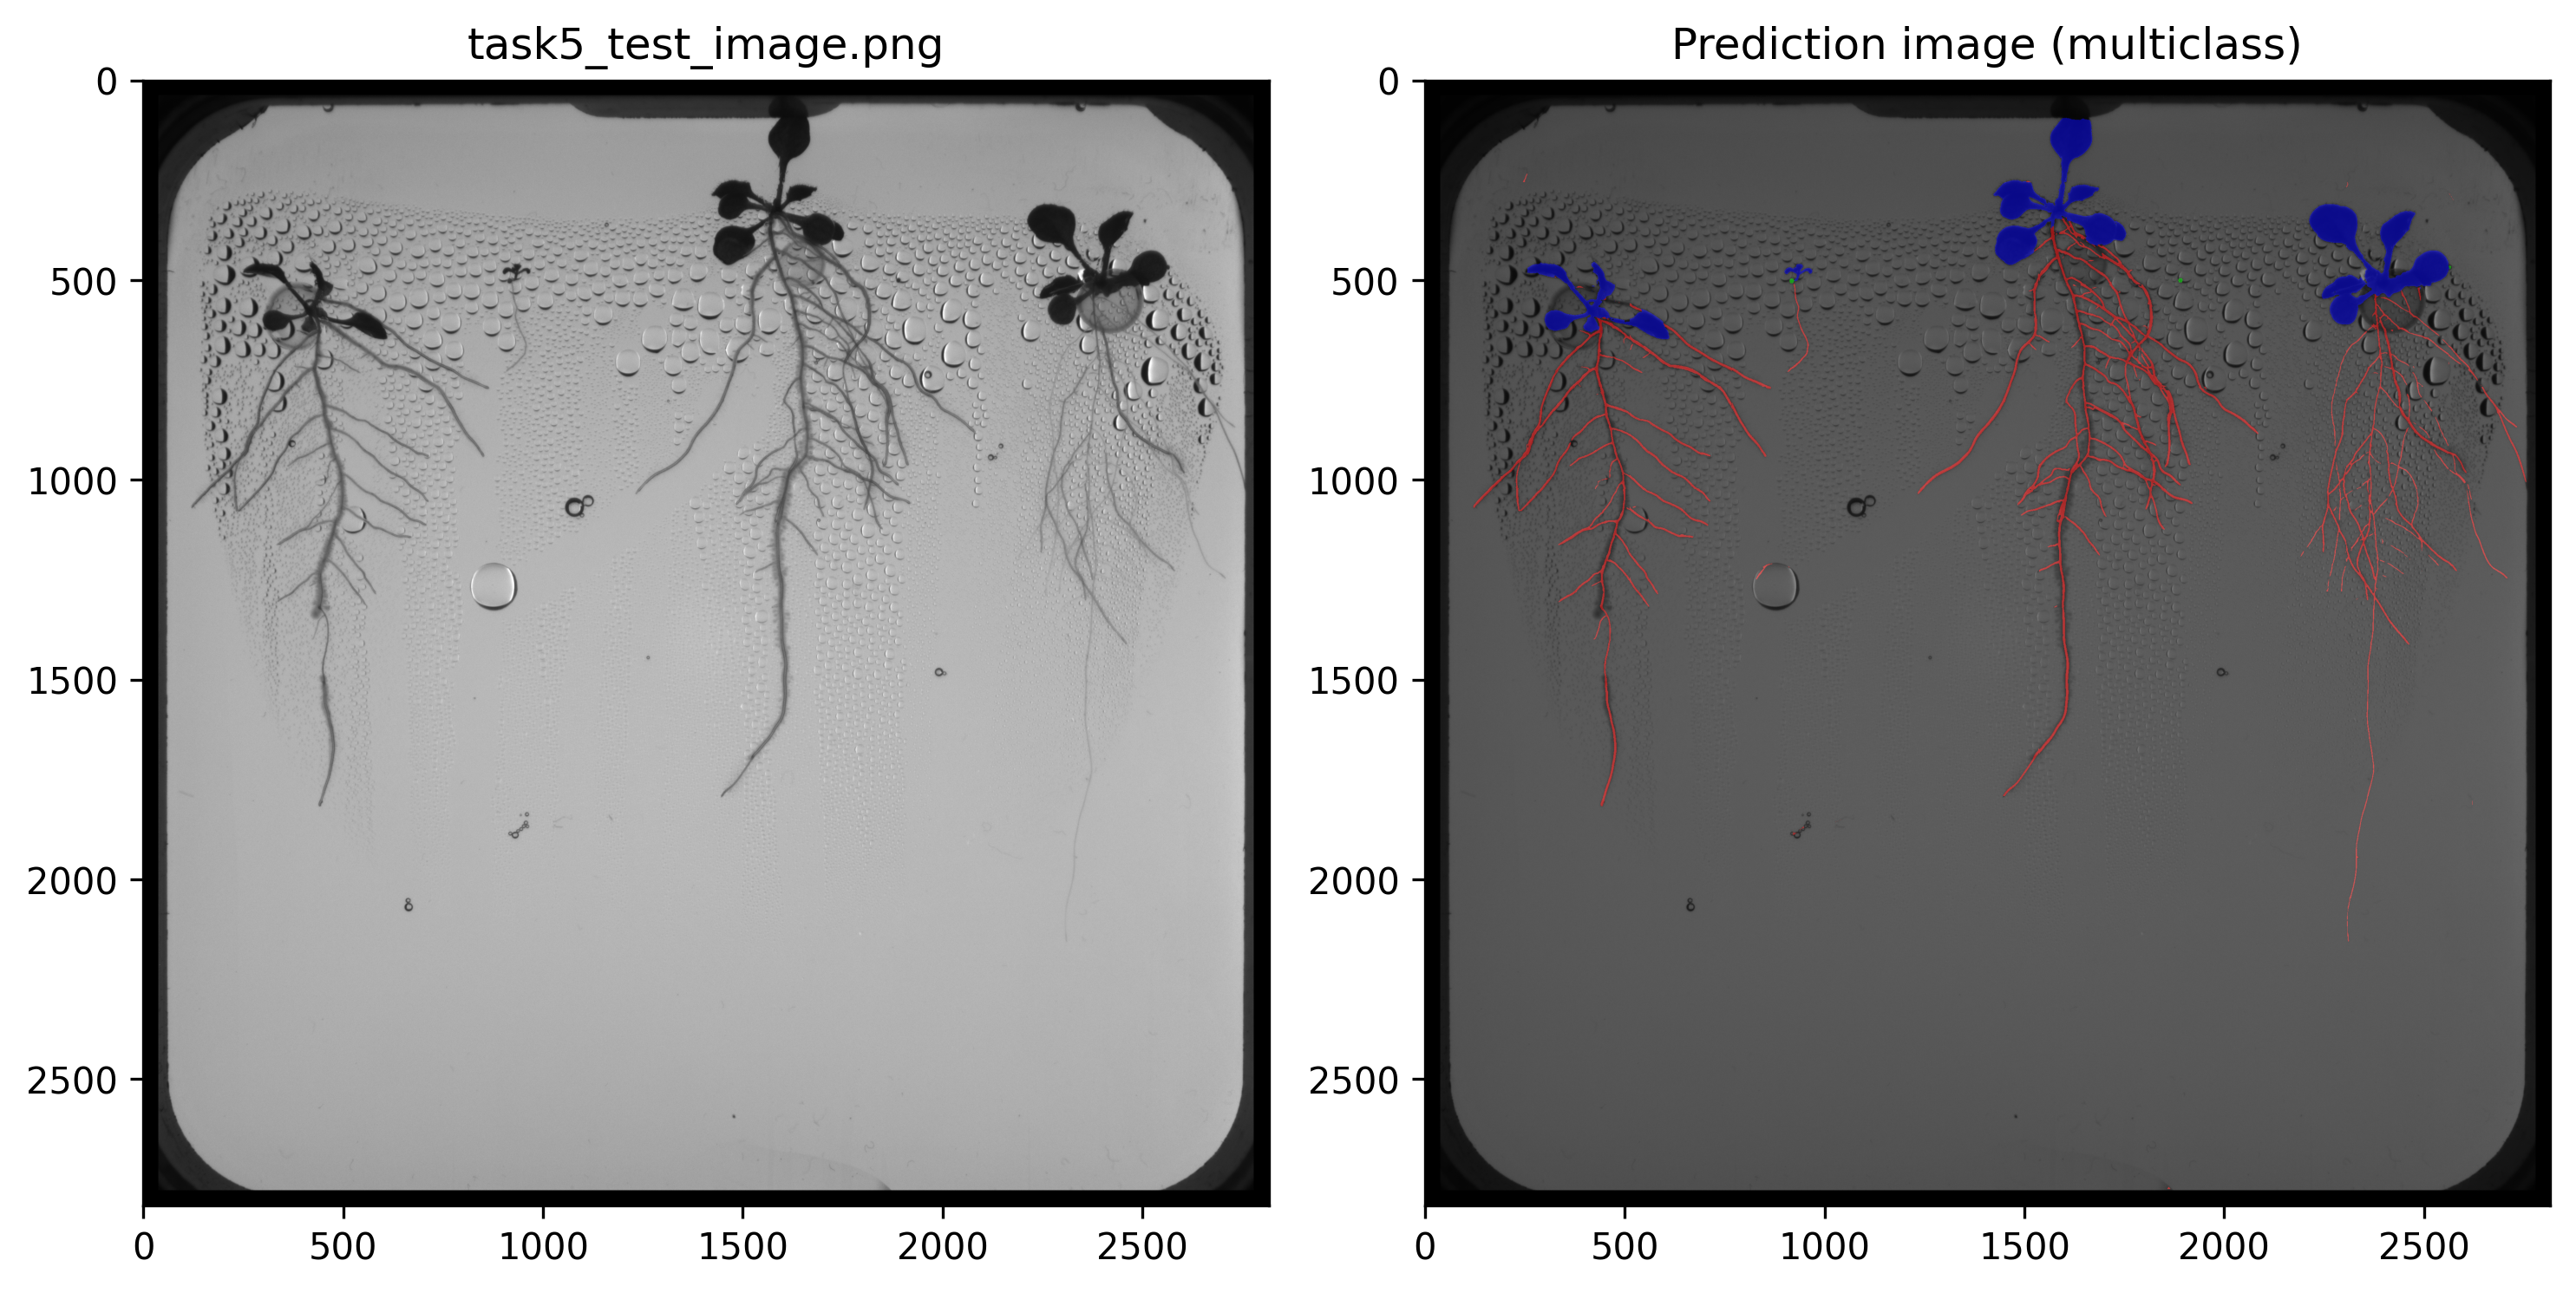

In [10]:
# PATCH
patches = patchify(petri_dish_padded, (patch_size, patch_size, 3), step=patch_size)
patches = patches.squeeze(2)
i = patches.shape[0]
j = patches.shape[1]

patches = patches.reshape(-1, patch_size, patch_size, 3)
patches.shape
patches_for_model = patches
print("patches_for_model:", patches_for_model.shape)

# PREDICT
predicted_masks = model.predict(patches_for_model)
n_classes = predicted_masks.shape[-1]
print("predicted_masks shape:", predicted_masks.shape)
predicted_classes = np.argmax(predicted_masks, axis=-1).astype(np.uint8)

print("Labels:")
print(np.unique(predicted_classes))

# UNPATCH
predicted_grid = predicted_classes.reshape(i, j, patch_size, patch_size)
predicted_mask = unpatchify(predicted_grid, petri_dish_padded.shape[:2])

# class colors
root_color  = [1.0, 0.0, 0.0]  # red
shoot_color = [0.0, 0.0, 1.0]  # blue
seed_color  = [0.0, 1.0, 0.0]  # green

# make RGB version of the padded dish, normalized to [0,1]
im_rgb = petri_dish_padded.astype(float) / 255.0

# empty overlay (same shape)
overlay_mask = np.zeros_like(im_rgb, dtype=float)

# paint each class
overlay_mask[predicted_mask == 1] = root_color
overlay_mask[predicted_mask == 2] = shoot_color
overlay_mask[predicted_mask == 3] = seed_color

# blend overlay with original image
alpha = 0.5  # transparency
overlay_image = (1 - alpha) * im_rgb + alpha * overlay_mask
overlay_image = np.clip(overlay_image, 0, 1)

f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))

ax[0].imshow(petri_dish_padded)
ax[0].set_title('task5_test_image.png')

im = ax[1].imshow(overlay_image)
ax[1].set_title('Prediction image (multiclass)')

plt.tight_layout()
plt.show()

In [ ]:
print("Inference output range:", predicted_mask.min(), predicted_mask.max())


As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

In [ ]:
def unpadder(padded_image, padding):
    top_padding, bottom_padding, left_padding, right_padding = padding

    # remove the exact padding added during padder()
    h_end = None if bottom_padding == 0 else -bottom_padding
    w_end = None if right_padding  == 0 else -right_padding

    unpadded = padded_image[
        top_padding : h_end,
        left_padding : w_end
    ]

    return unpadded

def undo_extract_dish(mask_crop, original_shape, bbox):
    y_m, y2, x_m, x2 = bbox
    H, W = original_shape

    full_mask = np.zeros((H, W), dtype=mask_crop.dtype)
    full_mask[y_m:y2, x_m:x2] = mask_crop

    return full_mask


In [ ]:
petri_dish_padded.shape

In [ ]:
image.shape

In [ ]:
# Apply the corrections
predicted_mask_corrected = unpadder(predicted_mask, padding)
predicted_mask_corrected.shape

In [ ]:
full_mask = undo_extract_dish(predicted_mask_corrected, image.shape, bbox)

In [ ]:
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: Plot such an image to prove alignment.
root_color = [1, 0, 0]   # Red for root mask

im_rgb = np.dstack([image, image, image])

overlay_root = np.zeros_like(im_rgb, dtype=float)

alpha = 1  # Transparency level

overlay_root[full_mask == 1 ] = root_color

overlay_image = im_rgb / 255  # Normalize image
overlay_image += alpha * overlay_root
overlay_image = np.clip(overlay_image, 0, 1)  # Clip values to keep them within [0, 1]

plt.figure(dpi=300)
plt.imshow(overlay_image)

In [ ]:
# REQUIREMENT: Save the predicted mask, it is a deliverable.
# REQUIREMENT: Input/Output size must be the same.
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: The predicted mask must be binary.
# REQUIREMENT: Non-root pixels must be 0, root pixels must be 255 (unlike Task 1)
# REQUIREMENT: naming convention task5_test_image_prediction_studentname_studentnumber.png
binary_mask = (full_mask == 1).astype(np.uint8)
mask_image = (binary_mask * 255).astype(np.uint8)
unique_vals = np.unique(mask_image)
assert set(unique_vals.tolist()).issubset({0, 255})
assert(mask_image.shape == image.shape)
cv2.imwrite('task5_test_image_prediction_maciej_243552.png', mask_image)

Note: I have trained the model on the Y2B_23 dataset, since there are no labels for Y2B_24 dataset yet. The test image is from Y2B_24, this is why the predicted mask is suboptimal. Therefore do not take the performance of this prediction as a reference. Your predictions should be much better than this.

**NOTE:** The code below is a test for task 6

In [ ]:
plt.imshow(full_mask, cmap='gray')

In [ ]:
to_png = full_mask*(255//3)
unique_vals_png = np.unique(to_png) # should be in {0, 85, 170, 255} where 255 corresponds to class 3 - not root
assert set(unique_vals_png.tolist()).issubset({0, 85, 170, 255})
assert(to_png.shape == image.shape)
cv2.imwrite('task5_test_image_pred_to_task_6.png', to_png)